In [1]:
import json
from pathlib import Path
import sys
sys.path.insert(1, '../src')
sys.path.insert(1, '../src/utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.cluster import OPTICS
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from preprocessing import Preprocessing
from config import Config

import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Variables


In [4]:
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## Load data

In [5]:
with open(input_path, encoding="utf-8") as f:
    data = json.load(f)
data_df = pd.json_normalize(data['papers'])
corpus = data_df["abstract"]
if use_title:
    corpus = data_df["title"] + " " + corpus 


## Preprocessing

In [6]:
config = Config.from_file("config_notebook.yaml")
corpus = Preprocessing(
        corpus,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:09, 131.69it/s]


### TD-IDF

The TfidfVectorizer does additionally also tokenization and stop word removal. Use two different methods of vectorizing

In [7]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

In [8]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus =  vectorizer.fit_transform(corpus["token"])  

# Clustering

In [9]:
def fit_model(model, corpus):
    model.fit(corpus)

In [10]:
tdidf_optics_clustering = OPTICS(n_jobs=6)
tdidf_optics_clustering.fit(tfidf_corpus.toarray())

OPTICS(n_jobs=6)

In [11]:
pickle.dump(tdidf_optics_clustering, open('optics_data/optics_tdidf_optics_clustering', 'wb'))

In [12]:
tdidf_optics_clustering_sklearn_prepocessed = OPTICS(n_jobs=6)
tdidf_optics_clustering_sklearn_prepocessed.fit(tfidf_corpus_sklearn_preprocessed.toarray())

OPTICS(n_jobs=6)

In [13]:
pickle.dump(tdidf_optics_clustering_sklearn_prepocessed, open('optics_data/optics_tdidf_optics_clustering_sklearn_prepocessed', 'wb'))

In [14]:
def print_top_terms(model, corpus, vectorizer):
    print('Number of clusters:', len(model.cluster_hierarchy_))

In [15]:
print_top_terms(tdidf_optics_clustering, tfidf_corpus, vectorizer)
print_top_terms(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed, vectorizer_sklearn)

Number of clusters: 3
Number of clusters: 2


# Visualization

In [16]:
def visualize_clustering_result(model, corpus):
    space = np.arange(len(corpus.toarray()))
    reachability = model.reachability_[model.ordering_]
    labels = model.labels_[model.ordering_]
    
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    
    # Reachability plot
    colors = ['g.', 'r.', 'b.', 'y.', 'c.']
    for klass, color in zip(range(0, 5), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        ax1.plot(Xk, Rk, color, alpha=0.3)
    ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
    ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
    ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
    ax1.set_ylabel('Reachability (epsilon distance)')
    ax1.set_title('Reachability Plot')

    # OPTICS
    colors = ['g.', 'r.', 'b.', 'y.', 'c.']
    for klass, color in zip(range(0, 5), colors):
        Xk = corpus.toarray()[model.labels_ == klass]
        ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
    ax2.plot(corpus.toarray()[model.labels_ == -1, 0], corpus.toarray()[model.labels_ == -1, 1], 'k+', alpha=0.1)
    ax2.set_title('Automatic Clustering\nOPTICS')
    
    plt.show()

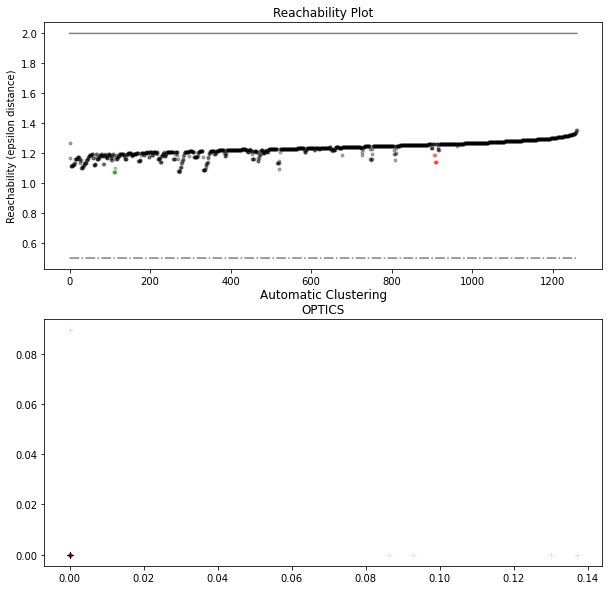

In [17]:
visualize_clustering_result(tdidf_optics_clustering, tfidf_corpus)

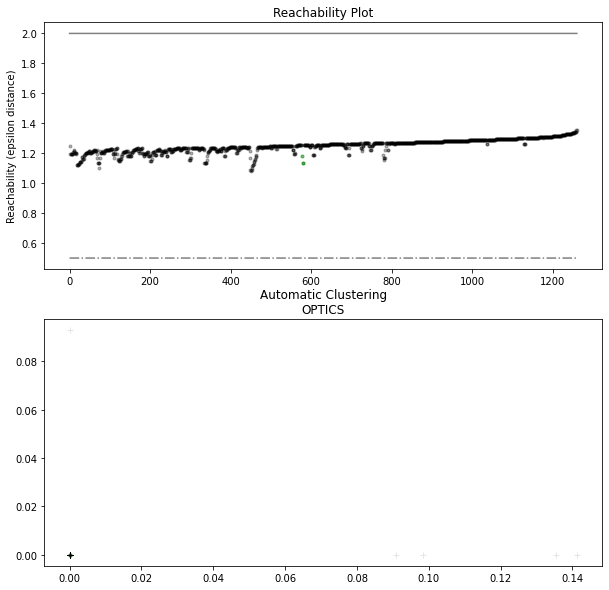

In [18]:
visualize_clustering_result(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed)

# Try different arguments for `OPTICS`

Without sklearn:
min_samples: 5, max_eps: 5


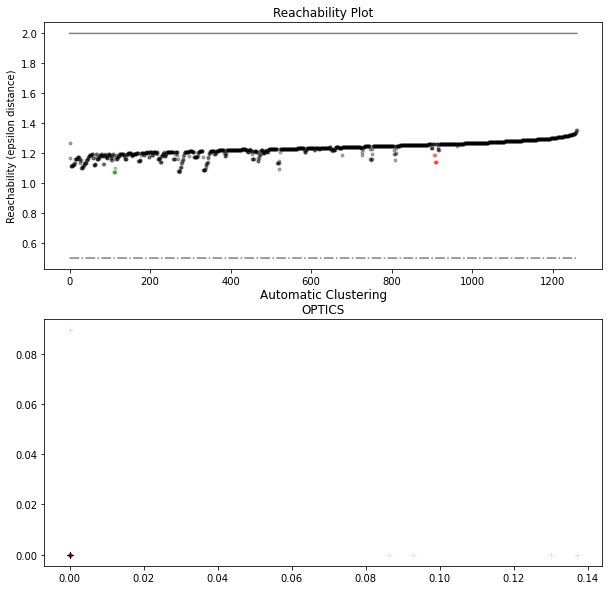

Number of clusters: 3
min_samples: 5, max_eps: inf


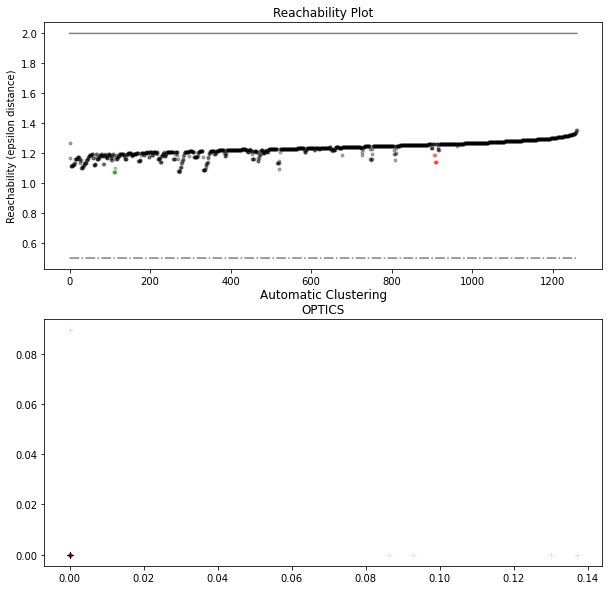

Number of clusters: 3
min_samples: 10, max_eps: 5


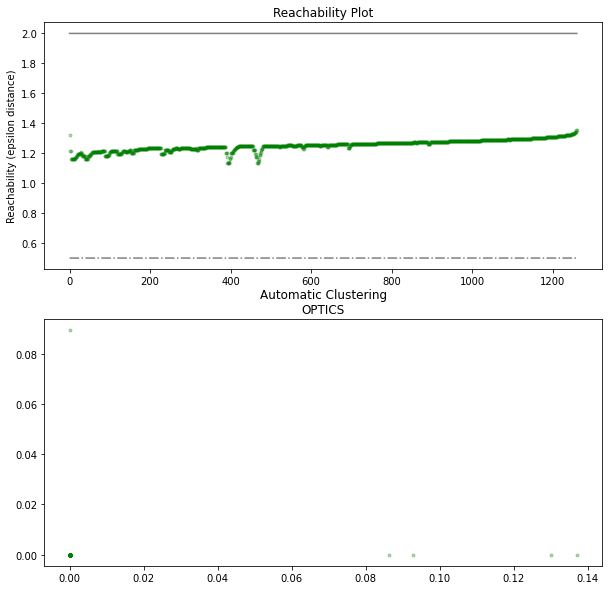

Number of clusters: 1
min_samples: 10, max_eps: inf


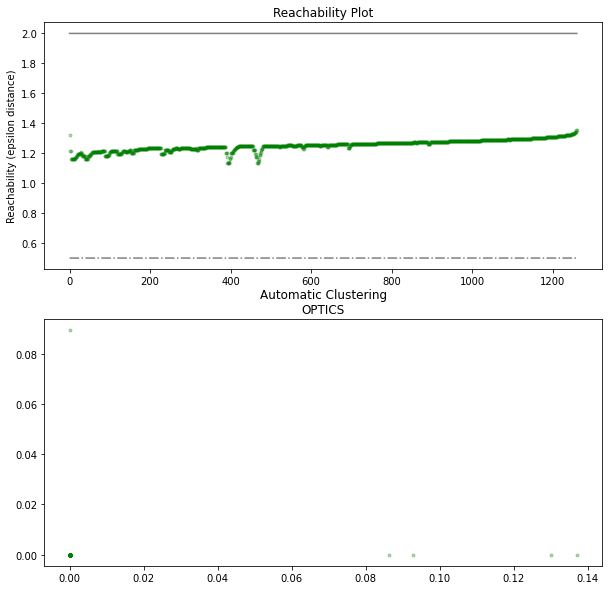

Number of clusters: 1
min_samples: 20, max_eps: 5


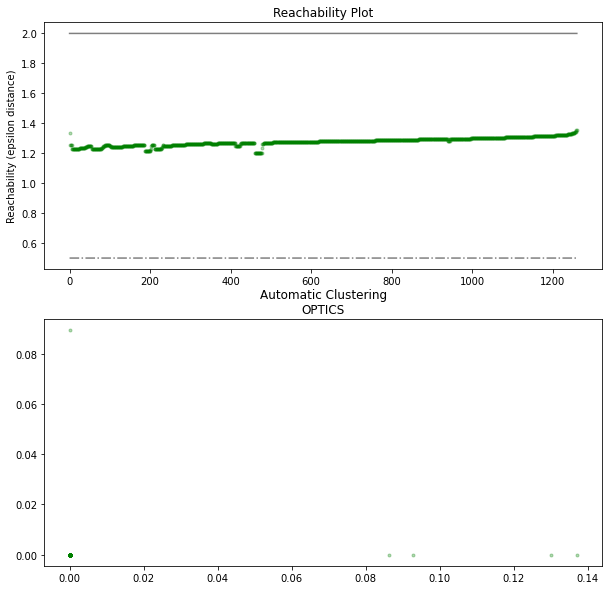

Number of clusters: 1
min_samples: 20, max_eps: inf


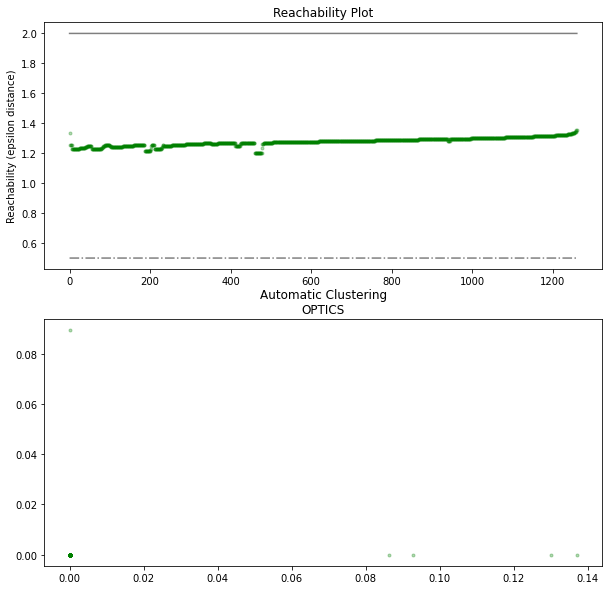

Number of clusters: 1

With sklearn:
min_samples: 5, max_eps: 5


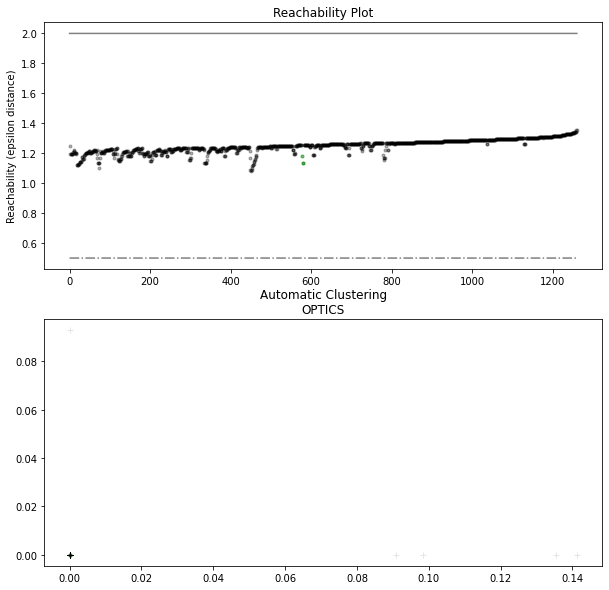

Number of clusters: 2
min_samples: 5, max_eps: inf


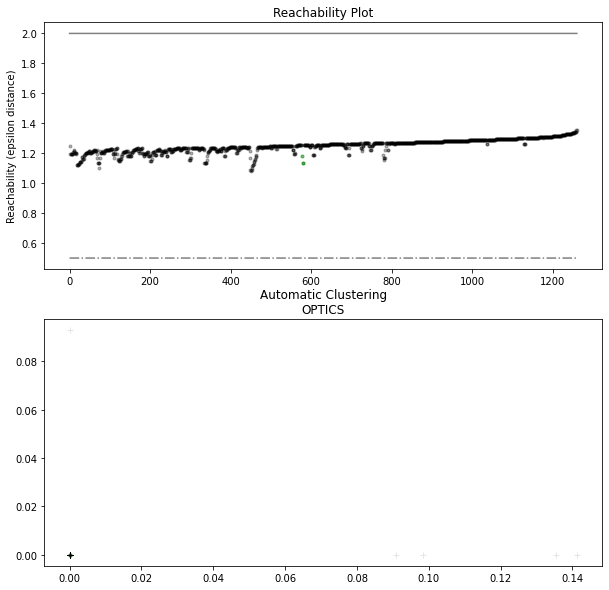

Number of clusters: 2
min_samples: 10, max_eps: 5


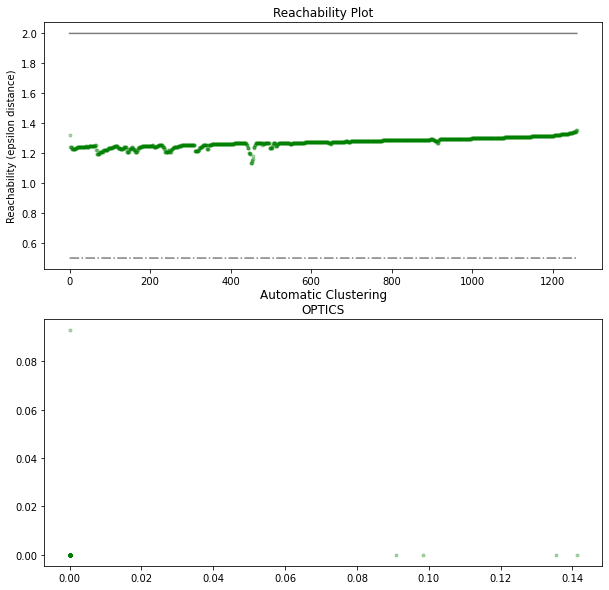

Number of clusters: 1
min_samples: 10, max_eps: inf


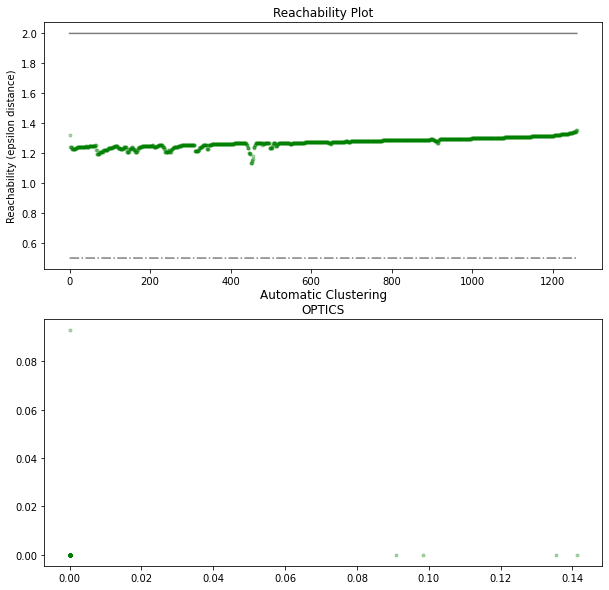

Number of clusters: 1
min_samples: 20, max_eps: 5


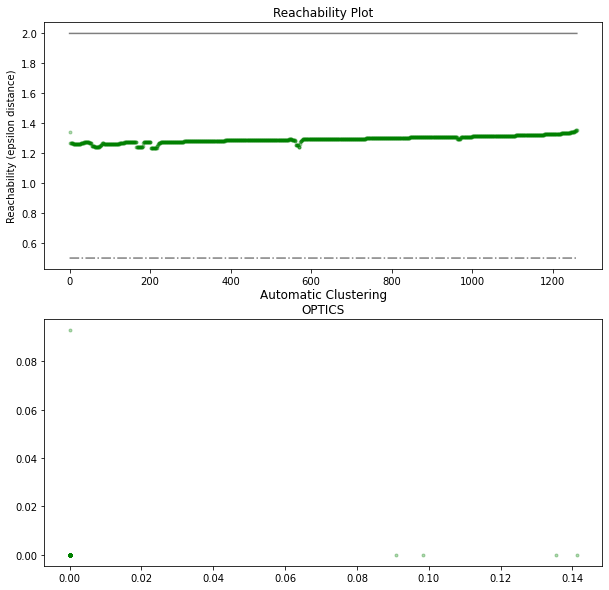

Number of clusters: 1
min_samples: 20, max_eps: inf


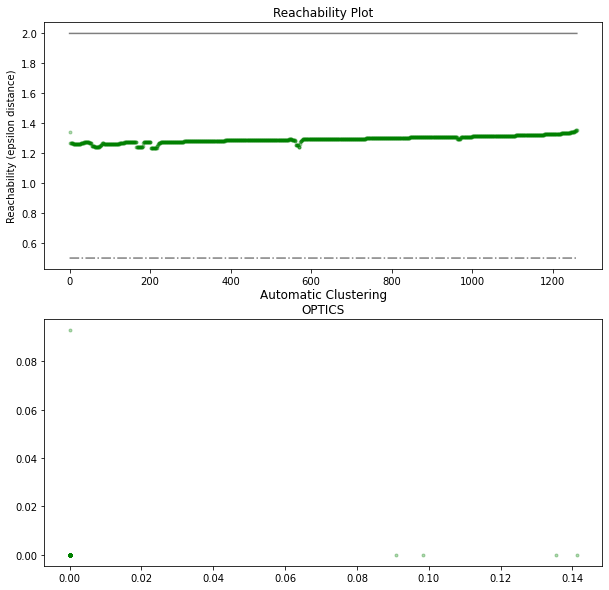

Number of clusters: 1


In [19]:
min_samples = [5, 10, 20]
max_eps = [5, np.inf]

print('Without sklearn:')
for samples in min_samples:
    for eps in max_eps:
        print(f'min_samples: {samples}, max_eps: {eps}')
        
        tdidf_optics_clustering = OPTICS(min_samples=samples, max_eps=eps, n_jobs=6)
        fit_model(tdidf_optics_clustering, tfidf_corpus.toarray())
        
        visualize_clustering_result(tdidf_optics_clustering, tfidf_corpus)
        print_top_terms(tdidf_optics_clustering, tfidf_corpus, vectorizer)
        
        pickle.dump(tdidf_optics_clustering, open(f'optics_data/optics_wo-sklearn_{samples}_{eps}', 'wb'))
        
print('\nWith sklearn:')
for samples in min_samples:
    for eps in max_eps:
        print(f'min_samples: {samples}, max_eps: {eps}')
        
        tdidf_optics_clustering_sklearn_prepocessed = OPTICS(min_samples=samples, max_eps=eps, n_jobs=6)
        fit_model(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed.toarray())
        
        visualize_clustering_result(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed)
        print_top_terms(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed, vectorizer_sklearn)
        
        pickle.dump(tdidf_optics_clustering_sklearn_prepocessed, open(f'optics_data/optics_w-sklearn_{samples}_{eps}', 'wb'))